# Keras Uncertainty Example - MC Dropout

These examples accompany the talk "Uncertainty Quantification in Neural Networks with Keras" at PyData Global 2020.
It is meant to show a complete pipeline of training a model and evaluating its uncertainty using the keras_uncertainty library.

Please make sure that you have keras_uncertainty and keras (not tf.keras) installed before running these code samples. You can install keras_uncertainty with the following command:

    pip install --user git+https://github.com/mvaldenegro/keras-uncertainty.git
    
Parts of this code are taken from the Keras code examples, particularly the mnist_cnn.py example at https://raw.githubusercontent.com/keras-team/keras/master/examples/mnist_cnn.py

The first step is to import the necessary modules:

In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

import keras_uncertainty
from keras_uncertainty.models import MCDropoutClassifier
from keras_uncertainty.utils import classifier_calibration_error, classifier_calibration_curve

import numpy as np

Using TensorFlow backend.


We then import the MNIST dataset and format it appropriately.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

And then build a simple convolutional neural network model and train it. Note that until this step there is nothing particularly different than a standard neural network model.

In [3]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=32,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))



Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 122s 2ms/step - loss: 0.1917 - accuracy: 0.9423 - val_loss: 0.0488 - val_accuracy: 0.9844
Epoch 2/12
60000/60000 [==============================] - 120s 2ms/step - loss: 0.0820 - accuracy: 0.9754 - val_loss: 0.0354 - val_accuracy: 0.9868
Epoch 3/12
60000/60000 [==============================] - 76s 1ms/step - loss: 0.0620 - accuracy: 0.9811 - val_loss: 0.0310 - val_accuracy: 0.9897
Epoch 4/12
60000/60000 [==============================] - 110s 2ms/step - loss: 0.0534 - accuracy: 0.9837 - val_loss: 0.0281 - val_accuracy: 0.9905
Epoch 5/12
60000/60000 [==============================] - 98s 2ms/step - loss: 0.0436 - accuracy: 0.9863 - val_loss: 0.0296 - val_accuracy: 0.9910
Epoch 6/12
60000/60000 [==============================] - 92s 2ms/step - loss: 0.0393 - accuracy: 0.9871 - val_loss: 0.0266 - val_accuracy: 0.9915
Epoch 7/12
60000/60000 [==============================] - 98s 2

Then we make some predictions on the test set, and evaluate the calibration error and plot the reliability diagram (also called calibration curve).

Calibration Error: 0.17777258710864052


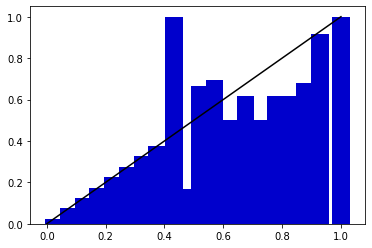

In [18]:
test_preds = model.predict(x_test)
y_confs = np.max(test_preds, axis=1)
y_preds = np.argmax(test_preds, axis=1)
y_classes = np.argmax(y_test, axis=1)

calib_error = classifier_calibration_error(y_preds, y_classes, y_confs, num_bins=20)

print('Calibration Error:', calib_error)

x, y = classifier_calibration_curve(y_preds, y_classes, y_confs, num_bins=20)

import matplotlib.pyplot as plt

plt.bar(x, y, width=0.06, color=(0.0, 0.0, 0.8))
plt.plot([0, 1], [0, 1], color='black')

From the results about it can be seen that the model is overconfident for most confidences over 0.5, while it is underconfident for confidences around 0.4. This is not ideal behavior. The calibration error is also high at around 0.17. This is standard behavior for neural networks that do not have uncertainty quantification built into the model.

We now use the same trained model and enable Dropout at inference time, which transforms the model into an approximate Bayesian neural network. We also re-evaluate the calibration error and calibration curve.

Calibration Error: 0.1178451793870661


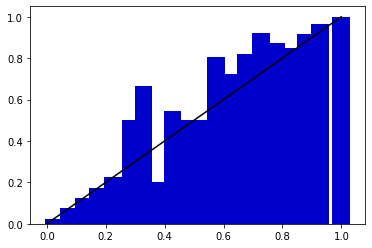

In [27]:
mc_model = MCDropoutClassifier(model)
test_preds = mc_model.predict(x_test, num_samples=10)
y_confs = np.max(test_preds, axis=1)
y_preds = np.argmax(test_preds, axis=1)
y_classes = np.argmax(y_test, axis=1)

calib_error = classifier_calibration_error(y_preds, y_classes, y_confs, num_bins=20)

print('Calibration Error:', calib_error)

x, y = classifier_calibration_curve(y_preds, y_classes, y_confs, num_bins=20)

import matplotlib.pyplot as plt

plt.bar(x, y, width=0.06, color=(0.0, 0.0, 0.8))
plt.plot([0, 1], [0, 1], color='black')

It can now be see that the calibration error has dropped by almost 40% to 0.11, and the calibration curve is closer to perfect calibration, but now the model is underconfident for confidences over 0.5 and slight overconfident around 0.4.

We will now perform out of distribution detection, we will use the Fashion MNIST dataset since its images are in the same dimensions and format than the MNIST dataset.

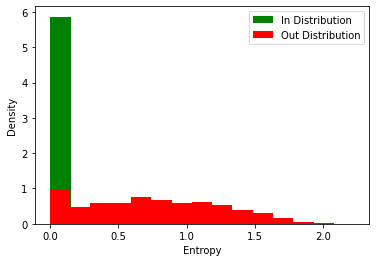

In [38]:
from keras.datasets import fashion_mnist

def entropy(data, axis=-1):
    return np.sum(-data * np.log(data + 1e-10), axis=axis)

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32')
x_test /= 255

fmnist_preds = mc_model.predict(x_test, num_samples=10)

fmnist_entropy = entropy(fmnist_preds)
mnist_entropy = entropy(test_preds)

plt.hist(mnist_entropy, bins=10, density=True, color='green', label='In Distribution')
plt.hist(fmnist_entropy, bins=15, density=True, color='red', label='Out Distribution')
plt.xlabel("Entropy")
plt.ylabel("Density")
plt.legend()

plt.savefig("ood-histograms.pdf", bbox_inches='tight')

These results show that most in-distribution examples (MNIST) have low entropy, close to 0, while the out of distribution examples (Fashion MNIST) have much higher entropy, with ranges from 0 to around 2.0 . This motivates that out of distribution examples can be detected by using the entropy of the predicted probabilities.

We will now visualize which examples have the lowest and highest predictive entropy in both the in distribution (MNIST) and out of distribution (Fashion MNIST) datasets.

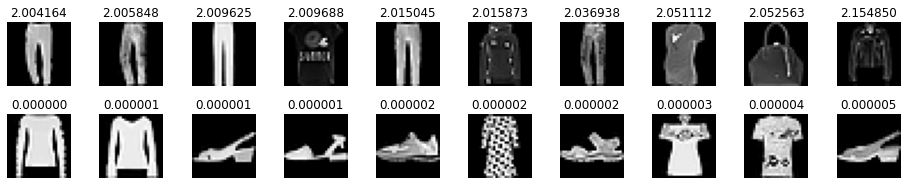

In [32]:
from mpl_toolkits.axes_grid1 import ImageGrid

def display_by_entropy(images, entropies, howmany=10):
    top_id = np.argsort(entropies, axis=0)[-howmany:]
    bottom_id = np.argsort(entropies, axis=0)[:howmany]
    
    fig = plt.figure(figsize=(16., 8.))
    grid = ImageGrid(fig, 111, nrows_ncols=(2, howmany), axes_pad=0.4)
    
    labels = ["{:3f}".format(entropies[i]) for i in top_id] + ["{:3f}".format(entropies[i]) for i in bottom_id]
    images = [images[i] for i in top_id] + [images[i] for i in bottom_id]
    
    for ax, img, label in zip(grid, images, labels):
        ax.imshow(img.squeeze(), cmap="gray")
        ax.set_axis_off()
        ax.set_title(label)
    
    #return fig

display_by_entropy(x_test, fmnist_entropy)

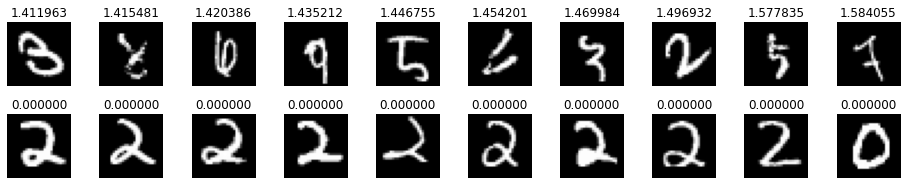

In [31]:
(_, __), (x_mnist, ___) = mnist.load_data()
x_mnist = x_mnist.reshape(x_mnist.shape[0], 28, 28, 1)
x_mnist = x_mnist.astype('float32')
x_mnist /= 255

display_by_entropy(x_mnist, mnist_entropy)

You can see from these results that generally out of distribution examples do obtain higher entropy, it does not happen for all examples, as some examples are given a low entropy that is similar to an in in distribution example. This could be because the model thinks they are visually similar to MNIST examples, for example shows and some shirts.

It should also be noted that some in distribution examples also get high entropy, usually numbers that are very ambiguously drawn and can easily be confused with other numbers, and these are usually misclassified as the labels are not always completely correct.